In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

print(tfp.__version__)


import numpy as np
import matplotlib.pyplot as plt

0.11.0


The following shows the ordering of shapes that we should always keep in mind when working with `Distribution` objects:

`(sample_shape, batch_shape, event_shape)` 

* `sample_shape` = number of samples (drawn from dist)
* `batch_shape` = number of distributions (in the batch)
* `event_shape` = number of dims/variables in the p.d.f

#### Univariate distributions - (One Random Variable)
We will first create some univariate distributions. There is a wide range of distributions available in the [distributions module](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions), of which we will only be using a few.

In [2]:
#create a normal distribution 
# loc=mean, scale=variance (std^2)

normal = tfd.Normal(loc=0., scale=1.)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

we can sample using the `.sample` method - specifying the dims of sample

In [3]:
single_sample = normal.sample()
print(single_sample)

multiple_samples = normal.sample(5)
print(multiple_samples)

multi_dim_sample = normal.sample((2,3))
print(multi_dim_sample)

#each elm is a value sampled from the normal dist we created

tf.Tensor(-0.114451244, shape=(), dtype=float32)
tf.Tensor([ 0.22345205  0.32086685 -0.59994525  0.5102353  -0.07895499], shape=(5,), dtype=float32)
tf.Tensor(
[[ 2.2094517   0.7331362   1.2682858 ]
 [-0.17111431 -0.81430364 -1.0971591 ]], shape=(2, 3), dtype=float32)


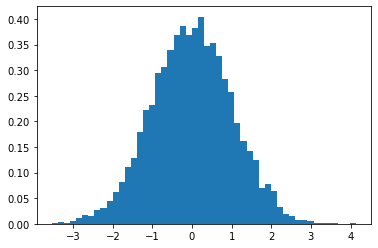

In [8]:
# Plot some samples

import matplotlib.pyplot as plt

z = normal.sample(10000).numpy()
plt.hist(z, bins=50, density=True)
plt.show()

`.prob` Method of a `Distribution` Object gives the value of the p.d.f at a certain value. Remember that this is not a probability, instead it is just the gradient of the cdf at that pt! 
If the value is small it tells you the change in the cdf at this point is small which indicates values we observe from our random variable are unlikely to fall around this point! (likelihood is small).

the `.log_prob` Method computes the log of this value! 

In [10]:
# Compute prob / log-prob of test points
#computes the value of the probability density function at a particular value! remember this is not a probabilty, 
#its just the gradient of the cdf at that pt

#calculate the p.d.f of normal at the pt zero! - this is NOT the probability of getting zero (as that is zero for cont. var)
print(normal.prob(0))
#calculate the log prob (i.e the log(prob))
print(normal.log_prob(0))


tf.Tensor(0.3989423, shape=(), dtype=float32)
tf.Tensor(-0.9189385, shape=(), dtype=float32)


In [4]:
# Compute log-prob of a batch of test points

# create test points of shape (3,2)
test_pts = tf.random.normal((3,2))

#feed each one into p.d.f then take log
normal.log_prob(test_pts)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.9765985, -1.2587631],
       [-1.2480748, -1.4868529],
       [-0.9646536, -0.9204349]], dtype=float32)>

A single `Distribution` object can represent a batch of distributions of the same type:

In [5]:
# Create an exponential distribution

exp = tfd.Exponential(rate=1)
exp
#single exponential dist - both batch_shape and event_shape is empty

<tfp.distributions.Exponential 'Exponential' batch_shape=[] event_shape=[] dtype=float32>

In [6]:
# Create a batched exponential distribution - we have three seperate distributions with different rates, batched together 

batch_of_exps = tfd.Exponential(rate=[0.5,1.0,1.5]) #<-- feed in multiple rates 
batch_of_exps
# batch_shape = 3 meaning we have 3 exps in this batch 

<tfp.distributions.Exponential 'Exponential' batch_shape=[3] event_shape=[] dtype=float32>

In [7]:
#now lets take a sample!

batch_of_exps.sample()

#we get three values- one from each dist

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.2626081 , 0.35671028, 0.23322318], dtype=float32)>

In [18]:
#now taking multiple samples

batch_of_exps.sample(5) #<-- taking 5 samples from each dist - so should get shape (5, 3) - each column reps a dist

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[5.8114295 , 0.2752337 , 0.12167787],
       [2.4361832 , 1.1829559 , 0.719439  ],
       [3.2626817 , 1.9151893 , 0.8667169 ],
       [3.669655  , 1.0301782 , 1.2128085 ],
       [1.5552225 , 0.1835979 , 0.8388686 ]], dtype=float32)>

##### BroadCasting 

lets see it through computing log_probs of a batched dist

In [8]:
#create a single test pt
single_pt = tf.random.uniform(())

# send this pt to our batched dist and work out the log_prob
print(batch_of_exps.log_prob(single_pt), end=2*'\n')

#whats happening? - well its taking that single point and broadcasting it across each dist in our batch. 
#i.e. tf works out the log_prob of our single pt for each dist in our batch. Hence we get a (3,) tensor!

#illistrating
#create each of our exps in our batch seperatly
exp_0_5 = tfd.Exponential(rate=[0.5])
exp_1 = tfd.Exponential(rate=[1.])
exp_1_5 = tfd.Exponential(rate=[1.5])

print(exp_0_5.log_prob(single_pt))
print(exp_1.log_prob(single_pt))
print(exp_1_5.log_prob(single_pt))

tf.Tensor([-1.0674007  -0.7485069  -0.71729517], shape=(3,), dtype=float32)

tf.Tensor([-1.0674007], shape=(1,), dtype=float32)
tf.Tensor([-0.7485069], shape=(1,), dtype=float32)
tf.Tensor([-0.71729517], shape=(1,), dtype=float32)


In [9]:
# now we create test_pts that is SAME dim as number of dist - and work out log_prob

test_pts = tf.random.uniform((3, ))
print(batch_of_exps.log_prob(test_pts))

#illistration
print(exp_0_5.log_prob(test_pts[0]))
print(exp_1.log_prob(test_pts[1]))
print(exp_1_5.log_prob(test_pts[2]))

#now one pt is sent to one dist! (1st to the 1st, 2nd to the 2nd, ... ) - no broadcasting! 

tf.Tensor([-0.82575005 -0.11042738 -0.35336366], shape=(3,), dtype=float32)
tf.Tensor([-0.82575005], shape=(1,), dtype=float32)
tf.Tensor([-0.11042738], shape=(1,), dtype=float32)
tf.Tensor([-0.35336366], shape=(1,), dtype=float32)


In [13]:
# when the dim of the test_pts is higher than the number of distributions in the batch
# we have to add a batch dim to the number of pts!
# then tf will broadcast this whole batch (of four pts) to each of the dists!

test_pts = tf.random.uniform((4,1))# <---- Added a batch dim 
print('test_pts', test_pts, end=2*'\n')
print(batch_of_exps.log_prob(test_pts), end=2*'\n')


#sending our first test pt into our first distribution hence [0, 0] elm
print(exp_0_5.log_prob(test_pts[0]))

#sending our final test point into our second dist - hence [3,1] elm
print(exp_1.log_prob(test_pts[3]))

#sending our third test_pt in to our our final dist (exp=1.5) hence [2, 2] elm!!! (remeber counting from zero!)
print(exp_1_5.log_prob(test_pts[2]))


test_pts tf.Tensor(
[[0.5486187 ]
 [0.25150812]
 [0.33863747]
 [0.33735406]], shape=(4, 1), dtype=float32)

tf.Tensor(
[[-0.9674565  -0.5486187  -0.41746292]
 [-0.81890124 -0.25150812  0.02820292]
 [-0.8624659  -0.33863747 -0.10249111]
 [-0.8618242  -0.33735406 -0.100566  ]], shape=(4, 3), dtype=float32)

tf.Tensor([-0.9674565], shape=(1,), dtype=float32)
tf.Tensor([-0.33735406], shape=(1,), dtype=float32)
tf.Tensor([-0.10249111], shape=(1,), dtype=float32)


#### Multivariate distributions
In the distributions seen so far, the `event_shape` property has been empty, indicating that the distribution is UNIVARIATE (one random variable). Here, we look at multivariate distributions.

`event_shape` is the number of dims/variables in the pdf of the distribution!

In [14]:
# ctreate a multi- variavte (2D) normal dist

#it takes the diaginal of the co-variate matrix which is var(x), var(y) - 2d case
mvn = tfd.MultivariateNormalDiag(loc=[1., 3.], scale_diag=[1., 2.])
mvn

#event space is 2d ie f(x1,x2) !! - see seaborn plot below!!!

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [15]:
#lets sample!

mvn.sample(3)

#taking three samples from a 2d dist - hence (3, 2) (remeber its sample_shape, batch_shape, event_shape)
#note this isnt batched distributions this is one distribution which is k-dimensional (k=2)
# each row is a sample - because its 2d each column represents each rand. var (x1, x2)! 

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1.4837075, 2.619496 ],
       [1.5060637, 0.4622066],
       [1.2953439, 3.3855722]], dtype=float32)>

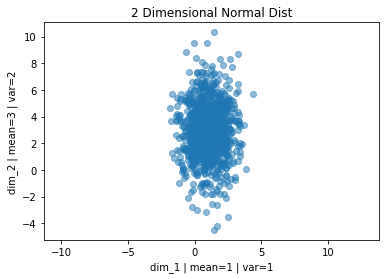

In [44]:
# Plot samples from the multivariate Gaussian

samples = mvn.sample(1000)
plt.scatter(samples[:, 0], samples[:,1], alpha=0.5)
plt.axis('equal')
plt.title('2 Dimensional Normal Dist')
plt.xlabel('dim_1 | mean=1 | var=1')
plt.ylabel('dim_2 | mean=3 | var=2')
plt.show()


In [46]:
# reminder! we have a 2 dimensional normal dist
mvn

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [17]:
#lets take the log_prob

#test_pts 2d (same dim as dist)
test_pts = tf.random.normal((2,))

#our dist takes 2 variables - so when we plug in these two test pts into the pdf (which takes two variables) 
#it will give us a scalar (grad of cdf) i.e. f(x_1 =1, x_2 =2) - imagine a flat (because 2d) church bell go 
#in x dirn (=1) then in y dirn (=2) and find value at that pt! (then take log of it)
mvn.log_prob(test_pts)

<tf.Tensor: shape=(), dtype=float32, numpy=-8.730436>

So far, we have seen how to define multivariate Gaussian distributions using `tfd.MultivariateNormalDiag`. This class allows you to specify a multivariate Gaussian with a diagonal covariance matrix $\sum$

In cases where the **variance is the same for each component**, i.e. $ \sum=\sigma^2 I$, this is known as a spherical or **isotropic Gaussian**. This name comes from the spherical (or circular) contours (level sets) of its probability density function, as you can see from the plot below for the two-dimensional case.

Covariance Matrix: tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)
mean's: tf.Tensor([0. 0.], shape=(2,), dtype=float32)


C:\Users\matth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


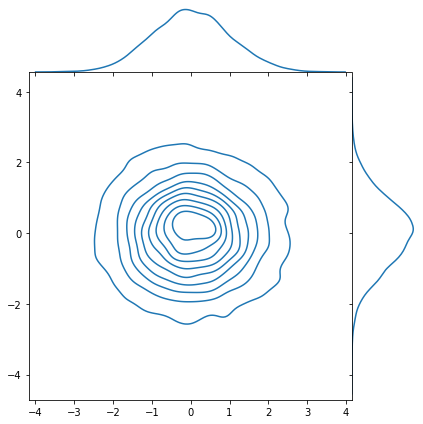

In [18]:
# Plot the approximate density contours of a 2d spherical Gaussian

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

spherical_2d_gaussian = tfd.MultivariateNormalDiag(loc = [0., 0.])
print('Covariance Matrix:', spherical_2d_gaussian.covariance())
print("mean's:", spherical_2d_gaussian.mean())
N = 10000
x = spherical_2d_gaussian.sample(N)
x1 = x[:, 0]
x2 = x[:, 1]
sns.jointplot(x1, x2, kind = 'kde', space = 0)
plt.show()

You can define a full covariance Gaussian distribution in TensorFlow using the Distribution `tfd.MultivariateNormalTriL`.

Mathematically, the parameters of a multivariate Gaussian are a mean $\mu$ and a covariance matrix $\sum$, and so the `tfd.MultivariateNormalTriL` constructor requires two arguments:
* loc, a Tensor of floats corresponding to $\mu$
* scale_tril, a lower-triangular matrix $L$ such that $LL^T = \sum$

We can also create a multivariate Gaussian using [`MultivariateNormalTriL`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalTriL), by passing in the lower triangular matrix $L$ such that $LL^T = \Sigma$, where $\Sigma$ is the covariance matrix. This is the Cholesky decomposition (see also [`tf.linalg.cholesky`](https://www.tensorflow.org/api_docs/python/tf/linalg/cholesky)).

In [19]:
# Construct a multivariate (2d) Gaussian with MultivariateNormalTriL

mu = [0.,0.]

#we are sending in L which can be obtained from co-variance matrix through Cholesky decomp! its a Lower triangular matrix
scale_tril = [[1., 0.],
             [0.6, 0.8]]
nonspherical_2d_gaussian = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)
nonspherical_2d_gaussian

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

In [20]:
print(nonspherical_2d_gaussian.covariance())

#lets check

sigma = tf.matmul(tf.constant(scale_tril), tf.transpose(tf.constant(scale_tril)))  # covariance matrix
print(sigma)

tf.Tensor(
[[1.  0.6]
 [0.6 1. ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.  0.6]
 [0.6 1. ]], shape=(2, 2), dtype=float32)


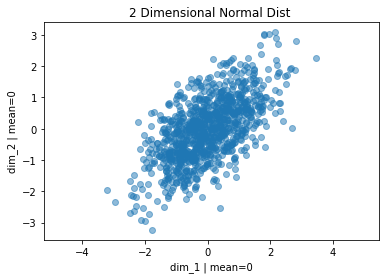

In [21]:
# Plot samples from the multivariate Gaussian
import matplotlib.pyplot as plt
samples = nonspherical_2d_gaussian.sample(1000)
plt.scatter(samples[:, 0], samples[:,1], alpha=0.5)
plt.axis('equal')
plt.title('2 Dimensional Normal Dist ')
plt.xlabel('dim_1 | mean=0')
plt.ylabel('dim_2 | mean=0')
plt.show()

C:\Users\matth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


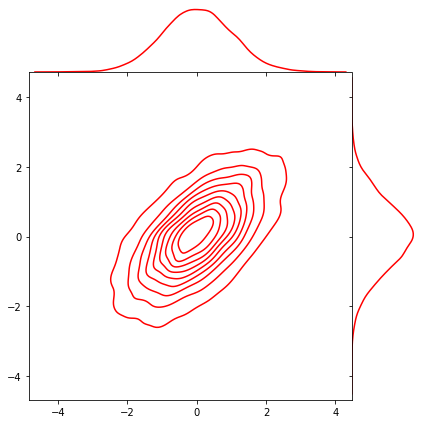

In [22]:
# Plot its approximate density contours
x = nonspherical_2d_gaussian.sample(N)
x1 = x[:, 0]
x2 = x[:, 1]
sns.jointplot(x1, x2, kind = 'kde', space = 0, color = 'r')

As you can see, the approximate density contours (level sets) are now elliptical rather than circular. This is because the **components of the Gaussian are correlated** - as the off diagionals which measure **co-variance are non-zero**!!!. For our spherical gaussian the off diagionals were zero indicating no correlation!

Also note that the marginal distributions (shown on the sides of the plot) are both univariate Gaussian distributions.

### The Cholesky decomposition
In the above example, we defined the lower triangular matrix $L$ and used that to build the multivariate Gaussian distribution. The covariance matrix is easily computed from $L$ where $LL^T = \sum$

The reason that we define the multivariate Gaussian distribution in this way - as opposed to directly passing in the covariance matrix - is that **not every matrix is a valid covariance matrix**. The covariance matrix must have the following properties:

* It is symmetric ($A = A^{T}$)
* It is positive (semi-) definite ($M$ is postive semi def if $z^{T}Mz$ is positive for every nonzero real column vector $z$)

NB: A symmetric matrix $M∈R^{d×d}$ is positive semi-definite if it satisfies $b^{T}Mb≥0$ for all nonzero $b∈R^{d}$. If, in addition, we have $b^{T}Mb=0⇒b=0$ then $M$ is positive definite. 

Since, or every real-valued symmetric positive-definite matrix $M$, there is a unique lower-diagonal matrix $L$ that has positive diagonal entries for which $LL^{T}=M$. This is called the Cholesky decomposition of M.

The Cholesky decomposition is a useful way of writing a covariance matrix

#### `tf.linalg.cholesky`
In case you have a valid covariance matrix $\sigma$ and would like to compute the lower triangular matrix $L$ above to instantiate a `MultivariateNormalTriL` object, this can be done with the `tf.linalg.cholesky` function.

In [23]:
# Define a symmetric positive-definite matrix
sigma = [[10., 5.], [5., 10.]]

In [24]:
# Compute the lower triangular matrix L from the Cholesky decomposition
scale_tril = tf.linalg.cholesky(sigma)
scale_tril

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3.1622777, 0.       ],
       [1.5811388, 2.738613 ]], dtype=float32)>

In [25]:
# Check that LL^T = Sigma
tf.linalg.matmul(scale_tril, tf.transpose(scale_tril))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[10.,  5.],
       [ 5., 10.]], dtype=float32)>

In [26]:
# Try to compute the Cholesky decomposition for a matrix with negative eigenvalues (not positive semi definite)
bad_sigma = [[10., 11.], [11., 10.]]

try:
    scale_tril = tf.linalg.cholesky(bad_sigma)
except Exception as e:
    print(e)

Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]


note: In cases where the matrix is only positive semi-definite, the Cholesky decomposition exists (if the diagonal entries of 
$L$ can be zero) but it is not unique.

For covariance matrices, this corresponds to the **degenerate case** where the probability density function collapses to a subspace of the event space.

The co-variance matrix has to be postive-definite for the cholesky decomposition to be meaning full!!

#### All together!

To create a multivariate Gaussian distribution with full covariance you need to:

* Specify parameters $\mu$ and either $\sum$(a symmetric positive definite matrix) or $L$ (a lower triangular matrix with positive diagonal elements), such that $\sum = LL^{T}$

* If only $\sum$ is specified, compute scale_tril = `tf.linalg.cholesky(sigma)`.

* Create the distribution: multivariate_normal = `tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)`.

In [29]:
# Create a multivariate (3d) Gaussian distribution
mu = [1., 2., 3.]
sigma = [
    [0.5, 0.1, 0.1],
    [0.1,  1., 0.6],
    [0.1, 0.6, 2.]
]

#create lower triangular matrix L using cholesky
scale_tril = tf.linalg.cholesky(sigma)
#multivariate normal
multivariate_normal = tfd.MultivariateNormalTriL(loc = mu, scale_tril = scale_tril)
multivariate_normal

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[3] dtype=float32>

In [30]:
# check mean and variiance 
print(multivariate_normal.mean())
print(multivariate_normal.covariance())

tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)
tf.Tensor(
[[0.49999997 0.1        0.1       ]
 [0.1        1.0000001  0.6       ]
 [0.1        0.6        2.        ]], shape=(3, 3), dtype=float32)


There are further ways of constructing a multivariate Gaussian: see the docs for [`MultivariateNormalDiagPlusLowRank`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalDiagPlusLowRank), [`MultivariateNormalLinearOperator`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalLinearOperator).

Multivariate distributions can also be batched together

In [36]:
# Create a batched multivariate Gaussian

#creating batch of 2, 3D multivariate normals (both have different means (loc) but SAME covariance matrix(scale_diag))
batched_mvn = tfd.MultivariateNormalDiag(loc=[[0., -1., -0.5], [1., 0.5, 0.]], scale_diag=[0.5,1.5,1.])
print(batched_mvn)

#correct! batch_shape=2, event_shape=3 (num of variables)

print(batched_mvn.mean()) # two separate mean (row)
print(batched_mvn.covariance()) # same co-variance mat

tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[2], event_shape=[3], dtype=float32)
tf.Tensor(
[[ 0.  -1.  -0.5]
 [ 1.   0.5  0. ]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[0.25 0.   0.  ]
 [0.   2.25 0.  ]
 [0.   0.   1.  ]], shape=(3, 3), dtype=float32)


In [37]:
# Sample from the batched multivariate Gaussian

batched_mvn.sample(4)

#we want to pull four samples from two 3d multivariate gaussians!
# recall (sample_shape, batch_shape, event_shape)

#YES! this makes sence - we have four samples (each block), then we have two batches of dist's (hence two rows in block),
# finally since each dist is 3d we have 3 columns represnting each variable (x1, x2, x3)

<tf.Tensor: shape=(4, 2, 3), dtype=float32, numpy=
array([[[ 0.7329596 ,  2.0429988 , -0.11019674],
        [ 1.2694634 ,  0.1003499 , -1.2222456 ]],

       [[-1.8050576 , -2.8023617 , -0.24687174],
        [ 0.52230936, -1.5938292 , -0.06213358]],

       [[-0.18299955,  3.4042845 , -0.70754063],
        [ 1.1947917 ,  1.5900884 ,  0.07148998]],

       [[-0.25341636, -3.2561073 ,  0.29760486],
        [ 1.5805423 , -0.6474316 ,  1.0778246 ]]], dtype=float32)>

### EXAMPLE

In [40]:
# EXERCISE: lets work out the resulting shape
# recall (sample_shape, batch_shape, event_shape)


mvn3 = tfd.MultivariateNormalDiag(loc=[[[2., 0., 0.5], [1., -0.5, 2.]]], scale_diag=[0.5, 1., 1.5])
print(mvn3)

# 3dim normal dist (can tell by 3 elm in co-variance diagional- multi var DIAG!!)
# we have a batch_shape of (1, 2).<--- tell this by the extra bracket for the means, this is the added batch dim
# so have (1, 2) batches of 3d gaussian 



test_pts = tf.random.normal((5, 1, 2, 1))
print(test_pts)

# count from front so we have 5 batches of 1 batch of (2,1). if we changed the 1 to a 2 we would have
# 5 batches of 2 batches of (2,1)


#now compute the log prob!
# each pdf takes three dims (as the dists are 3d) and we have two of them!
mvn3.log_prob(test_pts)

tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[1, 2], event_shape=[3], dtype=float32)
tf.Tensor(
[[[[ 0.18317516]
   [-0.12258255]]]


 [[[-1.541069  ]
   [-0.6238579 ]]]


 [[[-1.9888759 ]
   [-1.4752371 ]]]


 [[[ 0.35823125]
   [-1.1446743 ]]]


 [[[ 2.3952544 ]
   [ 1.0890217 ]]]], shape=(5, 1, 2, 1), dtype=float32)


<tf.Tensor: shape=(5, 1, 2), dtype=float32, numpy=
array([[[ -9.1099205,  -6.0619287]],

       [[-29.66069  ,  -9.280551 ]],

       [[-37.645763 , -17.882114 ]],

       [[ -7.928574 , -14.073743 ]],

       [[ -6.448427 ,  -3.9318962]]], dtype=float32)>

TO UNDERSTAND THIS EXAMPLE WE HAVE TO LOOK AT BROADCASTING!! - SOULTION BELOW

## Key: Broadcasting 

broadcasting is used in numpy to apply operations to arrays that are **not the same shape**. Buit will only broadcast if certain condition are met!

In [34]:
# Add two arrays with different shapes
a = np.array([[1.], [2.], [3.], [4.]])  # shape (4, 1)
b = np.array([0., 1., 2.])  # shape (3,) 

print(a, end=2*'\n')
print(b)

[[1.]
 [2.]
 [3.]
 [4.]]

[0. 1. 2.]


In [35]:
#let add them - they have different shapes so numpy uses broadcasting rules 
a + b

array([[1., 2., 3.],
       [2., 3., 4.],
       [3., 4., 5.],
       [4., 5., 6.]])

In [38]:
def dont_print():
    
    """To execute it, numpy:

Aligned the shapes of a and b on the last axis and prepended 1s to the shape with fewer axes:
 a: 4 x 1     --->    a: 4 x 1
 b:     3     --->    b: 1 x 3
Checked that the sizes of the axes matched (i.e. same number of axis - both have two) or were equal to 1:
 a: 4 x 1  
 b: 1 x 3
a and b satisfied this criterion.

KEY PART
Stretched both arrays on their 1-valued axes so that their shapes matched, then added them together.
a was replicated 3 times in the second axis, while b was replicated 4 times in the first axis.
This meant that the addition in the final step was

[ [1., 1., 1.],    +  [ [0., 1., 2.],  
  [2., 2., 2.],         [0., 1., 2.],  
  [3., 3., 3.],         [0., 1., 2.],  
  [4., 4., 4.] ]        [0., 1., 2.] ]

Addition was then carried out element-by-element, as you can verify by referring back to the output of the code cell above.
This resulted in an output with shape 4 x 3."""

Broadcasting rules describe how values should be transmitted when the **inputs to an operation do not match**.
In numpy, the broadcasting rule is very simple:

* Prepend 1s to the smaller shape,
* check that the axes of both arrays have sizes that are equal or 1,
* then stretch the arrays in their size-1 axes.

A crucial aspect of this rule is that it does not require the input arrays have the same number of axes.
Another consequence of it is that a **broadcasting output will have the largest size of its inputs in each axis**.

In [44]:
# Multiply two arrays with different shapes
a = np.array([[[0.01], [0.1]], [[1.00], [10.]]]) # shape (2, 2, 1)
b = np.array([[[2., 2.]], [[3., 3.]]]) # shape (2, 1, 2)
print('a')
print(a)
print('b')
print(b, end=2*'\n')


#then will have shape (2, 2, 2) the largest of each axis!
#because it stretches the last axis of a by two (i.e instead of one column there is now two)
#similarly for b it stretches the 1st axis (not batch dim =2) by two (i.e. instead of one row there are now two)
print("a * b" )
print(a * b )

a
[[[ 0.01]
  [ 0.1 ]]

 [[ 1.  ]
  [10.  ]]]
b
[[[2. 2.]]

 [[3. 3.]]]

a * b
[[[2.e-02 2.e-02]
  [2.e-01 2.e-01]]

 [[3.e+00 3.e+00]
  [3.e+01 3.e+01]]]


In [44]:
# Use broadcasting to compute an outer product

a = np.array([-1., 0., 1.]) #<-- shape (3,) (row vector)
b = np.array([0., 1., 2., 3.]) #<-- shape (4,) (row vector)

print(a[:, np.newaxis], end=2*'\n')
print(b, end=2*'\n')
#in order to compute outer product ab^T (with a and b column vectors in ab^T)

#NOTE: row x column = scaler (inner product: normal matrix multiplication-sum of products of elm))
#NOTE: column x row = matrix (outer product)

#we have to add a final axis to a to broadcast over (i.e. make a, a column vector)
a[:, np.newaxis] * b

#note on broadcasting: a=(3, 1) and b=(4,) so we will get (3, 4) - we add 1st dim to b (1,4) 
#stretch b in that 1st dim 3 times (i.e. add three rows (3,4)) and we stretch a in last dim by 4
# (i.e. add 4 columns (3,4))
#

[[-1.]
 [ 0.]
 [ 1.]]

[0. 1. 2. 3.]



array([[-0., -1., -2., -3.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  3.]])

#### Broadcasting for univariate TensorFlow Distributions
The broadcasting rule for TensorFlow is the same as that for numpy. For example, TensorFlow also allows you to specify the parameters of Distribution objects using broadcasting.

What is meant by this can be understood through an example with the univariate normal distribution. Say that we wish to specify a parameter grid for six Gaussians. The parameter combinations to be used, (loc, scale), are:

(0, 1)  
(0, 10)  
(0, 100)  
(1, 1)  
(1, 10)  
(1, 100)

A laborious way of doing this is to explicitly pass each parameter to tfd.Normal:

In [45]:
# Define a batch of Normal distributions without broadcasting
batch_of_normals = tfd.Normal(loc = [0., 0., 0., 1., 1., 1.], scale = [1., 10., 100., 1., 10., 100.])
batch_of_normals

#check mean (loc) and variance (scale)
print(batch_of_normals.loc)
print(batch_of_normals.scale)

tf.Tensor([0. 0. 0. 1. 1. 1.], shape=(6,), dtype=float32)
tf.Tensor([  1.  10. 100.   1.  10. 100.], shape=(6,), dtype=float32)


In [48]:
def dont_print():
    
    """A more succinct way to create a batch of distributions for this parameter grid is to use broadcasting.
Consider what would happen if we were to broadcast these arrays according the rule discussed earlier:

loc = [ [0.],
        [1.] ]
scale = [1., 10., 100.]

The shapes would be stretched according to

loc:   2 x 1 ---> 2 x 3
scale: 1 x 3 ---> 2 x 3

resulting in

loc = [ [0., 0., 0.],
        [1., 1., 1.] ]
scale = [ [1., 10., 100.],
          [1., 10., 100.] ]

which are compatible with the loc and scale arguments of tfd.Normal."""

In [46]:
# Define a batch of Normal distributions with broadcasting
loc = [[0.], [1.]]
scale = [1., 10., 100.]
another_batch_of_normals = tfd.Normal(loc = loc, scale = scale)
print(another_batch_of_normals, end=2*'\n')

#check mean (loc) and variance (scale)
print(another_batch_of_normals.loc, end=2*'\n')
print(another_batch_of_normals.scale)

tfp.distributions.Normal("Normal", batch_shape=[2, 3], event_shape=[], dtype=float32)

tf.Tensor(
[[0.]
 [1.]], shape=(2, 1), dtype=float32)

tf.Tensor([  1.  10. 100.], shape=(3,), dtype=float32)


now rather the six distributions in one batch we have our six distributions but spread over two batches i.e. (2,3)! But we have our six distributions!

In [52]:
test_pts = tf.random.normal((6,))
print(batch_of_normals.log_prob(test_pts))

test_pts_23 = tf.reshape(test_pts, (2,3))# <--- key in mind we have to reshape them to feed into our batched dists
print(another_batch_of_normals.log_prob(test_pts_23))

tf.Tensor([-1.0462968 -3.223001  -5.524175  -0.9254071 -3.2217205 -5.5242186], shape=(6,), dtype=float32)
tf.Tensor(
[[-1.0462968 -3.223001  -5.524175 ]
 [-0.9254071 -3.2217205 -5.5242186]], shape=(2, 3), dtype=float32)


(note: the values here are different because of the samples are different)

In [56]:
batch_of_normals.sample()

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([   0.15247743,  -10.734172  , -140.81631   ,    1.6252096 ,
          0.4704399 ,  132.72746   ], dtype=float32)>

In [57]:
another_batch_of_normals.sample()

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  1.6930197 ,   8.043403  ,  28.437397  ],
       [  0.36604214, -15.16872   , 162.08614   ]], dtype=float32)>

## Broadcasting with .prob and .log_prob (Univariate Dists)

In [54]:
# Define a batch of UNIVARIATE Normal distributions with broadcasting
loc = [[0.], [10.]]
scale = [1., 1., 1.]
another_batch_of_normals = tfd.Normal(loc = loc, scale = scale)
another_batch_of_normals

<tfp.distributions.Normal 'Normal' batch_shape=[2, 3] event_shape=[] dtype=float32>

We can feed in samples of any shape **as long as it can be broadcast againest our batch shape** for this example.

here we want to broadcast our sample to so that it is the same dimensions as our batch of normals. then we can feed into those dists. (so our distribution is univarate - pdf requires only on variable, x) 

In [68]:
# Use broadcasting along the SECOND axis with the prob method
sample = tf.random.uniform((2, 1))
another_batch_of_normals.prob(sample)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.0857256e-01, 3.0857256e-01, 3.0857256e-01],
       [1.3499406e-22, 1.3499406e-22, 1.3499406e-22]], dtype=float32)>

In [71]:
def dont_print():
    """ Our sample is [[1],
                       [2]]
        
        and we need this sample to be [[1], [1], [1],
                                       [2], [2], [2]]
                                       
       then we can feed it into our distributions [[d1], [d2], [d3]'
                                                   [d4], [d5], [d6]']
                                                   
                                                   i.e dist 1 will get x=1 where as d4 will get x=2 and we work out the pdf
                                                   values for this!!
                                                   
                                                   the broadcasting here is not related to multiplication!! its related to
                                                   feeding it into dist"""

In [75]:
#explaination

#when we broadcast in this way we are taking the dim that needs to be stretched and streching it will the WHOLE of the 
#orignial. i.e [[1], [2]] was taken two times in column dim so that we get to three columns!!

#here this wont work because we are taking a 2x2 and wanting to stretch it one time tn the column (to get to three)
# note that if the batch size of our distribution was [2,4] this would work because we can got two coullmns across!!
# likewise batch_size = [2, 5] wouldnt work but [2,12] would!!
try:
    sample = tf.random.uniform((2, 2))
    another_batch_of_normals.prob(sample)
except Exception as e:
    print(e)
    #causes an overlay! - visualisation (see down)
    
    
#however this will work! because we take a scalar (), and add two dims (1,1) 
#we can then broad cast this in the rows by 2 and the columns by three'
# then each dist will take the same value feed in element wise!
sample = tf.random.uniform(())
another_batch_of_normals.prob(sample)

Incompatible shapes: [2,2] vs. [3] [Op:RealDiv]


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.436044e-01, 3.436044e-01, 3.436044e-01],
       [1.565721e-20, 1.565721e-20, 1.565721e-20]], dtype=float32)>

In [55]:
## another example to make this absoultely clear!

# Define a batch of Normal distributions with broadcasting
loc = [[0.], [10.], [100], [1000]]
scale = [1., 1., 1.]
another_batch_of_normals = tfd.Normal(loc = loc, scale = scale)
another_batch_of_normals
#here we have a batch_shape of [4,3] i.e we have twelve distributions (0,1),     (0,1),    (0,1)
                                                                    # (10,1),    (10,1),   (10,1)
                                                                    # (100,1),   (100,1),  (100, 1)
                                                                    # (1000, 1), (1000,1), (1000,1)

<tfp.distributions.Normal 'Normal' batch_shape=[4, 3] event_shape=[] dtype=float32>

In [56]:
#here a scalar always works cause we can expand to neccesary dims then stretch
sample = tf.random.uniform(())
another_batch_of_normals.prob(sample)

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[3.7261260e-01, 3.7261260e-01, 3.7261260e-01],
       [2.8933223e-21, 2.8933223e-21, 2.8933223e-21],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [85]:
# a (2, 1) would work! because we can stretch it by it buy 2 in the rows and then stretch it by three in the columns
#(BOTH AXIS)  

sample = tf.random.uniform(())
another_batch_of_normals.prob(sample)

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[2.6131195e-01, 2.6131195e-01, 2.6131195e-01],
       [4.9828817e-19, 4.9828817e-19, 4.9828817e-19],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [89]:
# (1,3) works because only need to stretch in one dim! - the columns are taken care off just need to pull down 4 times 
#over rows
sample = tf.random.uniform((1,3))
print(another_batch_of_normals.prob(sample), end=2*'\n')



# (3,3) wont work because cant pull rows down by one if we have three rows in our sample! the least we could do is pull
# down another three (because sample already has three rows)  - hence wont work
try:
    sample = tf.random.uniform((3,3))
    another_batch_of_normals.prob(sample)
except Exception as e:
    print(e)


tf.Tensor(
[[3.2275724e-01 3.3672830e-01 3.5345739e-01]
 [4.1832352e-20 2.1952380e-20 9.3440350e-21]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]], shape=(4, 3), dtype=float32)

Incompatible shapes: [3,3] vs. [4,3] [Op:SquaredDifference]


In [79]:
# a (2,2) wouldnt work! - we can strech it in the rows to get 4 rows (multiple by two) 
#but cant expand by one in the colums because the column dim is already 2 and since we can only use the orginal shape 
#(i.e. cant cut it in half) then this wont work 

try:
    sample = tf.random.uniform((2, 2))
    another_batch_of_normals.prob(sample)
except Exception as e:
    print(e)
    
#a way to visulaise it would be to place the sample matrix in top left corner of dist batch_shape 
#and see if we can roll it over and keep within the dims of the dist batch_shape 

# in this example we have batch_shape=[4,3] and sample_matrix=[2,2] so if we roll our sample matrix over to the right
# it will pass the three rows by one!

Incompatible shapes: [2,2] vs. [3] [Op:RealDiv]


## Broadcasting for multivariate TensorFlow distributions

Recall that `MultivariateNormalDiag` has two parameter arguments: `loc` and `scale_diag`. 

When specifying a SINGLE distribution, these arguments are vectors of the same length:

In [6]:
# Define a multivariate Gaussian distribution without broadcasting
single_mvt_normal = tfd.MultivariateNormalDiag(loc = [0., 0.], scale_diag = [1., 0.5])
single_mvt_normal #<--- produce SINGLE (2d) multivate dist f(x1, x2)

#event shape = number of variables in the pdf

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [5]:
def dont_print():
    
    """The size of the final axis of the inputs determines the event shape for each distribution in the batch. 
    This means that if we pass say:

loc = [ [0., 0.],
        [1., 1.] ]

scale_diag = [1., 0.5]

such that

loc:        2 x 2
scale_diag: 1 x 2
                ^ final dimension is interpreted as EVENT dimension
            ^ other dimensions are interpreted as BATCH dimensions  

then a batch of two bivariate normal distributions will be created."""

In [9]:
# Define a multivariate Gaussian distribution with broadcasting
loc = [[0., 0.], 
       [1., 1.]]

scale_diag = [1., 0.5]
batch_of_mvt_normals = tfd.MultivariateNormalDiag(loc = loc, scale_diag = scale_diag)
batch_of_mvt_normals #<--- the final dims of the parameters (loc, scale_diag) is two therfore our dists event shape is 2
                     # passing in two means i.e theyre 2d. then since loc's first dim is 2 we will produce a batch of 2 dist

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[2] event_shape=[2] dtype=float32>

In [10]:
def dont_print():
    
    """Knowing that, for multivariate distributions, TensorFlow:

* interprets the final axis of an array of parameters as the event shape,
and broadcasts over the remaining axes,

* can you predict what the batch and event shapes will if we pass the arguments


loc = [ [ 1.,  1.,  1.],
        [-1., -1., -1.] ] # shape (2, 3)
scale_diag = [ [[0.1, 0.1, 0.1]],
               [[10., 10., 10.]] ] # shape (2, 1, 3)

to MultivariateNormalDiag?

Solution:

Align the parameter array shapes on their last axis, prepending 1s where necessary:

       loc: 1 x 2 x 3  
scale_diag: 2 x 1 x 3  

The final axis has size 3, so event_shape = (3)!! The remaining axes are broadcast over to yield

       loc: 2 x 2 x 3  
scale_diag: 2 x 2 x 3  

so batch_shape = (2, 2)."""

In [13]:
#lets check!

# Define a multivariate Gaussian distribution with broadcasting
loc = [[1.,  1.,  1.], [-1., -1., -1.]] # shape (2, 3)
scale_diag = [[[0.1, 0.1, 0.1]], [[10., 10., 10.]]] # shape (2, 1, 3)
another_batch_of_mvt_normals = tfd.MultivariateNormalDiag(loc = loc, scale_diag = scale_diag)
another_batch_of_mvt_normals

#YES!!

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[2, 2] event_shape=[3] dtype=float32>

As we did before lets also look at broadcasting when we have batches of multivariate distributions.

In [22]:
# Define a batch of Normal distributions with broadcasting
loc = [[0.], [1.], [0.]]
scale = [1., 10., 100., 1., 10, 100.]
another_batch_of_normals = tfd.Normal(loc = loc, scale = scale)
another_batch_of_normals

#rceall we have align the last dims and perpend ones
#3x1
#1x6
#therefore get a 3x6
# all of which are univariate - seen by the empty event shape and also since we have used a .Normal dist!

<tfp.distributions.Normal 'Normal' batch_shape=[3, 6] event_shape=[] dtype=float32>

The `Independent` distribution shifts all batch dimensions except the first into the event space. This can be changed with the `reinterpreted_batch_ndims` option:

In [23]:
# Create a multivariate Independent distribution
another_batch_of_mvt_normals = tfd.Independent(another_batch_of_normals)
another_batch_of_mvt_normals #<-- shifted our last batch dim to the event shape

#now we have three batches of 6d multivariate (Independent) normal dists 

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[3] event_shape=[6] dtype=float32>

Now for the broadcasting!!

In [25]:
another_batch_of_mvt_normals.sample()

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[ 2.6011517e-02, -8.8942623e+00, -3.8939114e+01,  4.2982289e-01,
         8.2547128e-01,  1.0562706e+02],
       [ 1.4069661e+00,  8.8499517e+00,  8.6275192e+01,  5.7300717e-01,
         1.8387951e+01,  1.3938741e+02],
       [-4.7264853e-01,  4.2287512e+00,  5.3369480e+01,  5.6979477e-01,
         2.4714441e+00,  1.6656868e+01]], dtype=float32)>

In [26]:
# Use broadcasting with the prob method
# B shaped input (broadcast over event)
sample = tf.random.uniform((3, 1))
another_batch_of_mvt_normals.prob(sample)

##so we have a sample that is (3,1) which we can broadcast to (3,6)!
## we then sub this broadcasted sample into each dist (we have three 6d multivariate normals)
## since when we sub in values (6 of them in this case) into our p.d.f it spits out a scalar which represnts the gradient
## of the c.d.f

## hence we have (3,) - which represents the value of each of the three dists p.d.fs!!

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.1650820e-09, 1.5321809e-09, 3.2271321e-09], dtype=float32)>

In [27]:
# Use broadcasting with the prob method
# E shaped input (broadcast over batch)
sample = tf.random.uniform((1, 6))
another_batch_of_mvt_normals.prob(sample)

## so we have a sample that is (1,6) which we can broad cast to a (3,6) (roll down rows!)
## then we plug into this broadcasted sample into our three dists - which works out the prob (value of the pdf at 6d-pts)
## spits out a scalar
## since we have three dists we get (3,) 

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.2205089e-09, 3.8016785e-09, 2.2205089e-09], dtype=float32)>

In [29]:
# Use broadcasting with the prob method
# [S,B,E] shaped input (broadcast over samples)

#[S,B,E] stands for [sample_shape, batch_shape, Event_shape]
sample = tf.random.uniform((2, 3, 6))
another_batch_of_mvt_normals.prob(sample)

##so our sample shape is (2, 3, 6) so we broadcast our dists to match this shape
##2x3x6 (sample)
##1x3x6 (dists - with prepended 1 - to match dim of input)

##2x3x6 (new dist shape - we just added a sample_dim)

##feed our input into our new broadcasted dists (just sample_dim added) and calculate the values of our dist at these pts
## (i.e. work out value of p.d.f -- returns a scalar )
## hence since we have three dists we get three scalars back BUT now we also have our sample_dim
## hence we get (2,3) returned - 2 is the sample_shape, 3 is the three values of our dists!

## just the above but with two samples!! and hence we are returning two samples!!!

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2.4401103e-09, 3.7835002e-09, 2.3601829e-09],
       [3.7999968e-09, 2.7241032e-09, 2.2872622e-09]], dtype=float32)>

In [30]:
# [S,b,e] shaped input where [b,e] can be broadcast agaisnt [B,E]
sample = tf.random.uniform((2, 1, 6))
another_batch_of_mvt_normals.prob(sample)


## in this case we have an input_dim = (2, 1, 6) and we have our dists_shape=(3,6) so both will need to be broadcasted

##2x1x6 (input)
##1x3x6 (dists - with added sample_dim too match input)
## BROADCASTING BOTH (take max for each dim - rolling out)
##2x3x6 both input and dists now have this shape

## similar to above we can then sub these matching shapes into the dist_shape - take the probability(the value of the pdf
## of our 6d multivariate dist - which returns a scalar (grad of cdf) - since we have three dists we get three scalars back)

## our sample_dim remains and hence we get (2,3) -- we are taking two seperate samples of our batches dists thats all- 
## theres no funny business

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2.1290045e-09, 3.5847842e-09, 2.1290045e-09],
       [1.7274912e-09, 4.0008250e-09, 1.7274912e-09]], dtype=float32)>

### FINALLY WE CAN DEAL WITH EXAMPLE FROM EARLIER 

In [31]:
# EXERCISE: lets work out the resulting shape!
# recall (sample_shape, batch_shape, event_shape)


#create our multivariate dist
mvn3 = tfd.MultivariateNormalDiag(loc=[[[2., 0., 0.5], [1., -0.5, 2.]]], scale_diag=[0.5, 1., 1.5])
mvn3

## this has event shape 3 because scale_diag is 3d
## the batch_dim is (1, 2) -- because we have two means given but they are wrapped in another dim (bracket [])!

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[1, 2] event_shape=[3] dtype=float32>

In [32]:
# create our test points
test_pts = tf.random.normal((5, 1, 2, 1))
test_pts

<tf.Tensor: shape=(5, 1, 2, 1), dtype=float32, numpy=
array([[[[-9.0936862e-02],
         [ 2.0393014e+00]]],


       [[[ 7.5899637e-01],
         [-2.9042490e+00]]],


       [[[-1.9825829e+00],
         [ 9.0568740e-04]]],


       [[[ 1.4316862e+00],
         [-8.1980431e-01]]],


       [[[-1.0199932e+00],
         [-1.1388546e+00]]]], dtype=float32)>

In [35]:
# what is the shape of this:
mvn3.log_prob(test_pts)

##recall:`(sample_shape, batch_shape, event_shape)` 

##so we have input shape (5,1,2,1) and dist_shape (1,2,3) so both need to be broadcasted! (dist_shape needs a sample_dim)
##also event_dim of the input(final_dim = 1) is not the same as our event_shape for our dists! -- so broadcast both 

##5x1x2x1 (input)
##1x1x2x3 (dist_shape -- with sample_dim added (perpending 1))
##BROADCASTING BOTH

##5X1X2X3 (BOTH input_shape and dists_shape have this shape!)

##now that they are broadcasted we can work out the prob (remember last dim represents the event_shape,so we have 3d dists)
##and we have 2 of them (batch_dim=2) therefore the proability will give (2,) back as p.d.f returns scalar and we have 2 dists

## therefore our final shape will be (5, 1, 2) -- (5,1) is the sample_dim which remain and the 2 is the batch_dims



## YESSSSSSSSSSSSSSSSSSSSSSSS !!!!!!!

<tf.Tensor: shape=(5, 1, 2), dtype=float32, numpy=
array([[[-11.294904 ,  -7.8537974]],

       [[ -5.8522577, -41.19047  ]],

       [[-37.52599  ,  -5.4790497]],

       [[ -4.3328547, -10.910601 ]],

       [[-21.743462 , -14.012021 ]]], dtype=float32)>

## The Independent Distribution

In [5]:
# Start by defining a batch of two univariate Gaussians
locs = [-1., 1]
scales = [0.5, 1.]
batch_of_normals = tfd.Normal(loc = locs, scale = scales)
batch_of_normals

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [12]:
j = np.repeat(t[:, np.newaxis], 2, axis = 1)
j.shape
j

array([[-4.        , -4.        ],
       [-3.99919992, -3.99919992],
       [-3.99839984, -3.99839984],
       ...,
       [ 3.99839984,  3.99839984],
       [ 3.99919992,  3.99919992],
       [ 4.        ,  4.        ]])

C:\Users\matth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\matth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


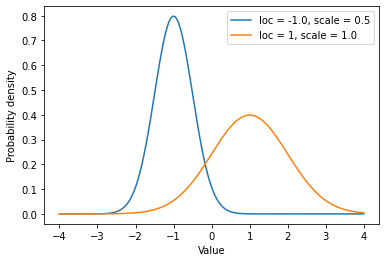

In [13]:
# Univariate density functions
import seaborn as sns

t = np.linspace(-4, 4, 10000)
#in order to feed these pts into our dists we need two columns of these pts (repeated- i.e. sending the same pts to each dist
# as a cloumn vector!
# add new axis - turn it into coulmn vect, then make two of them (np.repaeat(, 2, along column axis)) - easy!
# each column is a vector of densities for one distn
densities = batch_of_normals.prob(np.repeat(t[:, np.newaxis], 2, axis = 1)) 

sns.lineplot(t, densities[:, 0], label = 'loc = {}, scale = {}'.format(locs[0], scales[0]))
sns.lineplot(t, densities[:, 1], label = 'loc = {}, scale = {}'.format(locs[1], scales[1]))
plt.ylabel('Probability density')
plt.xlabel('Value')
plt.legend()
plt.show()

In [14]:
batch_of_normals

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [16]:
# combine these two univariate gaussians into a bivariate Gaussian with independent components

# Use Independent to convert the batch shape to the event shape
bivariate_normal_from_Independent = tfd.Independent(batch_of_normals, reinterpreted_batch_ndims = 1)
#note:reinterpreted_batch_ndims is the number of rightmost batch dims which will be regarded as event dims.
bivariate_normal_from_Independent

#now our two univaraiate normals have become one bivariate normal 

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

C:\Users\matth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


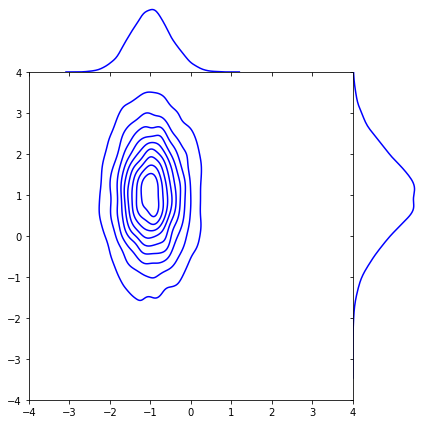

In [17]:
# Create a plot showing joint density contours and marginal density functions
samples = bivariate_normal_from_Independent.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
sns.jointplot(x1, x2, kind = 'kde', space = 0, color = 'b', xlim = [-4, 4], ylim = [-4, 4])

### We can use MultivariateNormalDiag to create the equivelent dist!

In [18]:
# Use MultivariateNormalDiag to create the equivalent distribution

# Note that diagonal covariance matrix => no correlation (off-diag are zero (co-variance part)) => independence
# (for the multivariate normal distribution)
bivariate_normal_from_Multivariate = tfd.MultivariateNormalDiag(loc = locs, scale_diag = scales)
bivariate_normal_from_Multivariate

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

C:\Users\matth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


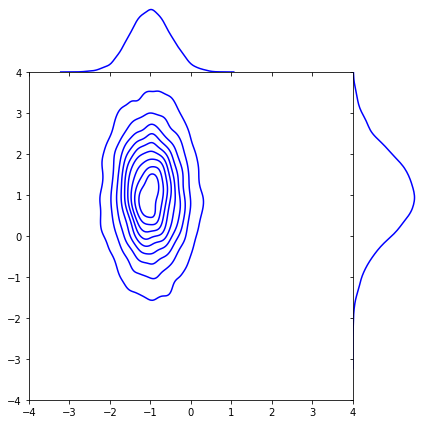

In [19]:
# Plot the joint density function of bivariate_normal_from_Multivariate - same as bivariate_normal_from_Independent
samples = bivariate_normal_from_Multivariate.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
sns.jointplot(x1, x2, kind = 'kde', space = 0, color = 'b', xlim = [-4, 4], ylim = [-4, 4])

### Shifting batch dimensions to event dimensions using reinterpreted_batch_ndims

In [22]:
# By default all batch dims except the first are transferred to event dims
loc_grid = [[-100., -100.], [100., 100.], [0., 0.]]
scale_grid = [[1., 10.], [1., 10.], [1., 1.]]

#both mean matrix and covariance matrix are same dim (3,2) there fore we get (3,2) normals (i.e. 6 normal dists)


normals_batch_3by2_event_1 = tfd.Normal(loc = loc_grid, scale = scale_grid)
normals_batch_3by2_event_1
#batch_shape is [3,2] meaning we have six normal dists in our batch

<tfp.distributions.Normal 'Normal' batch_shape=[3, 2] event_shape=[] dtype=float32>

In [24]:
# now we use reinterpreted_batch_ndims to shift all but the first batch_dim to the evnt_dims
normals_batch_3_event_2 = tfd.Independent(normals_batch_3by2_event_1)
normals_batch_3_event_2

# We now have a batch of 3 bivariate normal distributions,
# each parametrised by a row of our original parameter grid

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[3] event_shape=[2] dtype=float32>

In [29]:
# Evaluate log_prob
normals_batch_3_event_2.log_prob(value = [[-10., 10.], [100., 100.], [1., 1.]])

#each of dist gives a scaler for the log_prob and since we have 3 dists we get (3,) shape

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.1146406e+03, -4.1404624e+00, -2.8378770e+00], dtype=float32)>

In [28]:
# Can reinterpret _all_ batch dimensions as event dimensions
normals_batch_1_event_3by2 = tfd.Independent(normals_batch_3by2_event_1, reinterpreted_batch_ndims = 2)
normals_batch_1_event_3by2

#now we have empty batch_shape
#hence we have one dist with an event shape of [3,2]

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[3, 2] dtype=float32>

In [31]:
# Evaluate log_prob
normals_batch_1_event_3by2.log_prob(value = [[-10., 10.], [100., 100.], [1., 1.]])

#now we get just a single scaler - one dist with event_shape (3,2) - we feed in a (3,2) test_pts

<tf.Tensor: shape=(), dtype=float32, numpy=-4121.619>

# Bijectors 

In this section we will look at bijectors, which are another fundamental building block in TensorFlow Probability. Bijectors constitute the invertible and differentiable **transformations** that we will use to construct normalising flows (ie transform random vairables). The [bijectors module](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors) has a range of in-built bijector functions, which can be composed to make complex transformations.

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Two simple bijectors are the `Scale` and `Shift` bijectors. which do what they say on the tin!

In [6]:
# CREATE Scale and Shift bijectors

scale = tfb.Scale(3.0) #scale by const (multiply by 3)
shift = tfb.Shift(-5) # shift by const (add -5)

In [7]:
# Draw samples from a standard Normal distribution

normal = tfd.Normal(loc=0, scale=1.)
z = normal.sample(1000)

* `.forward()` method computes the (forward) bijector ------> X = g(Y)

* `.inverse()` method computes the inverse (undoes the bijector) ------> X = g-1(Y))

In [8]:
# Pass the samples through the forward method of each bijector

#forms a chain:
h=scale.forward(z) # scale normal
x=shift.forward(h) #shift result of scaled normal 

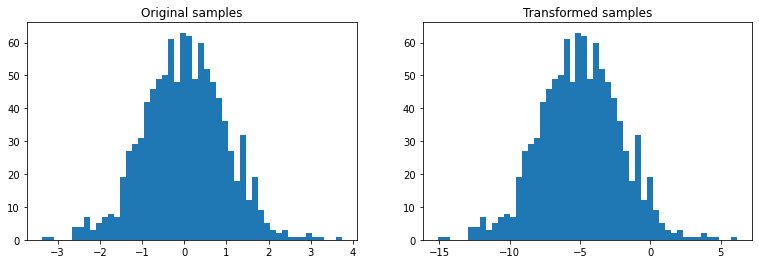

In [10]:
# Plot the original and transformed samples

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)
plt.hist(z.numpy(), bins=50)
plt.title("Original samples")

plt.subplot(1, 2, 2)
plt.hist(x.numpy(), bins=50)
plt.title("Transformed samples")
plt.show()

# transformed samples have been scaled by 3 (rem: standard normal so mean is 0 hence scaling decimals - thats why
# little difference in width (spread) of dist) AND shifted by -5 (i.e added -5 to each pt)

The `Chain` method creates a Bijector which applies a sequence of bijectors!

In [11]:
# Chain the bijectors together

scale_and_shift_chain = tfb.Chain([shift, scale]) 
# chain bijector applied in reverse order!! scale then shift

#another way is to composite them !! though a bit dodge 
scale_and_shift_composite = shift(scale)



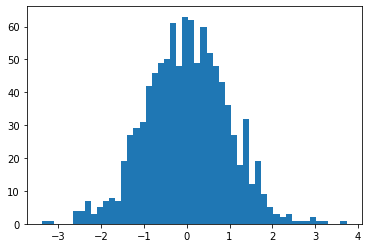

In [13]:
# Pass the transformed samples through the reverse method of each bijector

x_inv = scale_and_shift_chain.inverse(x)
plt.hist(x_inv.numpy(), bins=50)
plt.show()

## we have obtained the original z !!

### We can create a Batch of bijectors

In [28]:
# Create a batched Softfloor bijector

softfloor = tfb.Softfloor(temperature = [0.01, 0.1, 1.])
#this bijector operates on a scaler event space
# it Compute a differentiable approximation to tf.math.floor (floor function is a step function which drops decimals down
#i.e. 0.5 => 0 , 1.5 => 1. but floor fun is step => not differentiable!) the smaller the temp the closer it is to step
softfloor.parameters

{'temperature': [0.01, 0.1, 1.0], 'validate_args': False, 'name': 'softfloor'}

In [26]:
# Pass some test points through the bijector
import numpy as np 

test_pts = np.linspace(-2, 2, 1000)
transformed_pts = softfloor(test_pts[..., tf.newaxis])

#have to add new axis to prevent broadcasting error (shapes dont match)
# we have to pass our test_pts through as a column vector - such that broadcasting works
#1000x1 (test_pts)
#1x3
#broadcast
#1000x3

transformed_pts.shape

TensorShape([1000, 3])

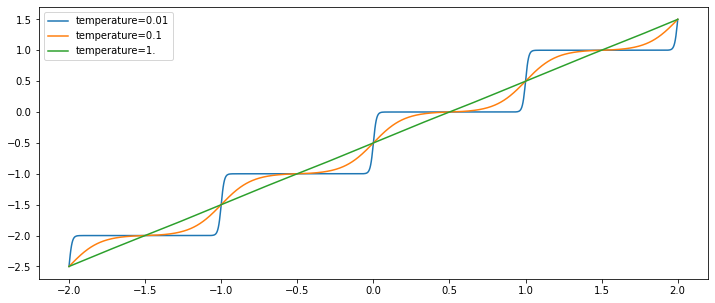

In [27]:
# Plot the transformed samples

plt.figure(figsize=(12, 5))
plt.plot(test_pts, transformed_pts[:, 0], label='temperature=0.01')
plt.plot(test_pts, transformed_pts[:, 1], label='temperature=0.1')
plt.plot(test_pts, transformed_pts[:, 2], label='temperature=1.')
plt.legend()
plt.show()

#we have each of 

### Computing the log_probs - change of variables formula!

In [32]:
# Draw samples from a standard Normal distribution

normal = tfd.Normal(loc=0, scale=1.)
z = normal.sample(1000)

In [33]:
# Create an Exp bijector - Compute Y = g(X) = exp(X).
exp = tfb.Exp()

# Compute the exp of the standard Normal samples - feed in our pts z
x = exp.forward(z)

Recall the change of variables formula:

$$
\log p_X(\mathbf{x}) = \log p_Z(\mathbf{z}) - \log \hspace{0.1ex}\left|\det J_f(\mathbf{z}) \right|
$$

**The change of variables formula tells us how to compute the probability density function of a random variable under a smooth invertible transformation.**


a reminder of whats going on =:

* our original (simple) dist which has p.d.f of Z (which is std Normal in this case)
* we create our transformation, f, (a bijector) which will take our orignial simple dist (normal) and transform to a complicated dist X. Our dist (bijector) is the exp dist in this case. note: the complicated dist is something we dont know yet but can get too via transoformation (I think)
* so the change of variables formalua tells you how to transform form the simple distribution to complaicated distribution.

We want the log of our complicated dist (evaluated at pts x)

which is equal to the log of our simple dist evaluated at the pts z (**pts z are sample drawn from our simple dist**) \
minus \
the log of the det of the jacobian of the transformation f (s.t X=f(Z) - which is our exponental dist) evaluated at z (remember `.forward()` means the bijector, `.inverse()` is the inverse

In [37]:
# Use log_det_jacobian to compute log_probs of transformed samples

logprob_x = normal.log_prob(z) - exp.forward_log_det_jacobian(z, event_ndims=0) #bijectors have method to calulate jacobian
logprob_x.shape

#we expect a 1000 elm array - since we are calucluating the .prob() which is grad of cdf - a scalar and taking log of that
#for each pt in our 1000 test_pts

TensorShape([1000])

And using the inverse transformation:

$$
\log p_X(\mathbf{x}) = \log p_Z(\mathbf{z}) + \log \hspace{0.1ex}\left|\det J_{f^{-1}}(\mathbf{x}) \right|
$$

In [38]:
# Repeat the calculation with the inverse_log_det_jacobian

logprob_x2 = normal.log_prob(z) + exp.inverse_log_det_jacobian(x, event_ndims=0) #bijectors method to calulate inverse jacob


#check if they are the same
np.allclose(logprob_x, logprob_x2)

True

#### The TransformedDistribution
The `TransformedDistribution` class provides a consistent API for **distributions defined by bijectors and base distributions.**

In [42]:
# Define the log-normal distribution with TransformedDistribution

transformed_normal = tfd.TransformedDistribution(distribution=normal, bijector=exp)

# same as 

# transformed distribution using exp and normal bijectors - i.e ytraking our normal and tranforming it via exp bijector
# this distribution is called a log-normal (exp of a normal!!)
log_normal_td = exp(normal)


# Confirm the log-probs of the transformed samples are the same as under a log-normal distribution
np.allclose(transformed_normal.log_prob(x), log_normal_td.log_prob(x))

True

The `TransformedDistribution` constructor also has `batch_shape` and `event_shape` arguments that can be used when the corresponding base distribution shape is empty.

In [5]:
# Create a TransformedDistribution from a batched bijector

softfloor = tfb.Softfloor(temperature=[0.01, 0.1, 1.]) #<--- batch_shape = 3
normal = tfd.Normal(loc=0., scale=1.) # <--- empty batch and event shape - just a univariate normal

# normal has empty batch and event shape but the bijector has a batch shape of 3. 
#so we have to define batch_shape or event_shape arg so that the transformeddistribution can interpret the 
#extra dims it is getting from the bijector!
trans_dist = tfd.TransformedDistribution(normal, softfloor, batch_shape=[3])
trans_dist

<tfp.distributions.TransformedDistribution 'softfloorNormal' batch_shape=[3] event_shape=[] dtype=float32>

In [12]:
#examples
print('Sample:', trans_dist.sample())
print('log_prob:', trans_dist.log_prob(4))

Sample: tf.Tensor([ 1.         -0.37324846 -0.9532184 ], shape=(3,), dtype=float32)
log_prob: tf.Tensor([ 34.35089   -8.346569 -11.002614], shape=(3,), dtype=float32)


`tfb.FillScaleTriL()` Transforms unconstrained vectors to TriL matrices (lower triangluar matrix) with positive diagonal.

In [14]:
# Set a scaling lower triangular matrix

fill_tril = tfb.FillScaleTriL()
scale_tril = fill_tril(tf.random.normal((2, 6))) #<-- 2 is batch, 6 is num of elm in lower tri
scale_tril

<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[ 0.95338726,  0.        ,  0.        ],
        [ 0.83799636,  1.0967792 ,  0.        ],
        [ 0.02764363, -0.77291757,  0.60039145]],

       [[ 1.0749294 ,  0.        ,  0.        ],
        [ 0.64208335,  0.5488217 ,  0.        ],
        [-0.11198012,  0.7284919 ,  0.47451457]]], dtype=float32)>

`ScaleMatvecTriL()`Compute Y = g(X; scale) = scale @ X.

In [15]:
# Define a bijector that operates on a rank >= 1 event space

scale_matvec_tril = tfb.ScaleMatvecTriL(scale_tril)

In [24]:
# Define TransformedDistribution with a batch and event shape

normal = tfd.Normal(loc=0., scale=1.)
mvn_tril_norm = tfd.TransformedDistribution(normal, scale_matvec_tril, batch_shape=[2], event_shape=[3])
#we are applying our scale_matvec_tril (bijector) to our normal dist and deifning the 
print(mvn_tril_norm)


# another way would be to 
mv_normal = tfd.MultivariateNormalDiag(loc=[0., 0., 0.], scale_diag=[1., 1., 1.])
mvn_tril_normdiag = tfd.TransformedDistribution(mv_normal, scale_matvec_tril, batch_shape=[2])
#we dont speficy event shape as mv_normal has a event shape but we still specify batch shape for bijector
print(mvn_tril_normdiag)

tfp.distributions.TransformedDistribution("scale_matvec_trilNormal", batch_shape=[2], event_shape=[3], dtype=float32)
tfp.distributions.TransformedDistribution("scale_matvec_trilMultivariateNormalDiag", batch_shape=[2], event_shape=[3], dtype=float32)


In [27]:
# Sample from the transformed distribution

mvn_tril_norm.sample()

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.6079714 ,  0.7753429 ,  1.5383224 ],
       [ 0.42480573,  0.5844168 , -0.39725563]], dtype=float32)>

## Exercise

Construct the distribution $\mathcal{N}(\mu, \Sigma)$, where $\mu = [0.5, -0.5]^T$ and $\Sigma = \left[\begin{array}{cc} 2 & 1\\ 1 & 2\end{array}\right]$, first using a `tfd.MultivariateNormalTriL` object, and then using a `tfd.TransformedDistribution` object with a `tfd.Normal(loc=0., scale=1.)` as a base distribution. Verify that the two representations are mathematically equivalent by computing log probs on a given sample.

In [153]:
sigma = [[2., 1.],
         [1., 2.]]
# Compute the lower triangular matrix L from the Cholesky decomposition
scale_tril = tf.linalg.cholesky(sigma)
print(scale_tril)
# Check that LL^T = Sigma
print(tf.linalg.matmul(scale_tril, tf.transpose(scale_tril)))

mv_normal = tfd.MultivariateNormalTriL(loc=[0.5, -0.5], scale_tril= scale_tril)
mv_normal

#yes so we have our bi-variate normal

tf.Tensor(
[[1.4142135  0.        ]
 [0.70710677 1.2247449 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.9999999  0.99999994]
 [0.99999994 2.        ]], shape=(2, 2), dtype=float32)


<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

In [155]:
scale_matvec_tril = tfb.ScaleMatvecTriL(scale_tril) #<--- scaled it by scale_tril ALSO NEED TO SCALE BY MEANS !!!
normal = tfd.Normal(loc=0., scale=1.)
mvn_tril_normdiag = tfd.TransformedDistribution(normal, scale_matvec_tril, event_shape=[2])
mvn_tril_normdiag

<tfp.distributions.TransformedDistribution 'scale_matvec_trilNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [156]:
test_sample = tf.random.normal((2,))

In [157]:
mv_normal.log_prob(test_sample)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.6269617>

In [158]:
mvn_tril_normdiag.log_prob(test_sample) ## not sure here!!! NEED TO WORK OUT HOW TO SCALE BY MEANS TOO!! MAYBE USING CHAIN?

<tf.Tensor: shape=(), dtype=float32, numpy=-2.8917184>